# Step 4.2: Feature Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error,r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load the Data set
df=pd.read_csv('Group_14_Clean_Data.csv')
df.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,P8,P9,P10,P11,P12,P13,P14,P15,P16,Powerall
0,316.5855,223.9277,182.3434,551.5497,7.8641,243.1339,361.0877,115.9284,78.6087,468.3799,...,82322.0277,98069.1011,86578.6330,93016.4133,63145.1829,98353.1952,80225.1390,98447.2846,97570.2225,1370374.145
1,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,83920.1033,80968.0044,87108.1328,68065.1856,99061.3812,77549.1426,99013.1628,78234.4337,84633.6493,1340929.765
2,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,97358.7395,93437.7170,69940.2554,92864.1192,60887.8095,72306.6556,81151.1515,83030.9726,94779.6131,1352031.511
3,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,280.2195,319.1130,...,80399.3841,89349.6141,85048.3860,70038.2271,92797.3569,97653.8121,74903.3740,71690.6549,96220.4768,1396754.375
4,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,97088.1761,81187.3982,63591.6729,92418.1977,82454.8256,97091.7749,85937.5437,66823.1572,93683.0996,1355708.577


In [3]:
# Define features and target variable

X = df.drop(columns=['Powerall']) 
y = df['Powerall'] 

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Perform scaling after splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Explanation of Lasso Regression for Feature Selection**

**Why Choose Lasso Regression?**

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a powerful method for feature selection due to the following reasons:

1. Automatic Feature Selection:

  * Lasso applies L1 regularization, which adds a penalty proportional to the absolute value of the coefficients. This results in some coefficients shrinking to exactly zero.

  * Features with zero coefficients are automatically excluded, making Lasso an efficient way to reduce dimensionality and retain only the most important features.

2. Handles Multicollinearity:

  * Lasso can handle multicollinearity (high correlation among features) by retaining only one of the highly correlated features, reducing redundancy in the dataset.

3. Simple and Effective:

  * Unlike wrapper methods that require multiple iterations of model building, Lasso selects features in a single step, saving computational resources.

4. Interpretable Results:

  * The selected features and their coefficients provide a clear understanding of their impact on the target variable.

**Reason of ussing Lasso:**

* The dataset contains a large number of features (positions and power outputs for multiple WECs).

* Not all features are equally important for predicting Powerall.

* Lasso identifies the most relevant features, improving model performance and interpretability while reducing overfitting.


In [15]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=3, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Identify important features
lasso_importances = pd.Series(data=lasso.coef_, index=X.columns)
important_features = lasso_importances[lasso_importances != 0].index
print("Selected Features by Lasso:", important_features.tolist())

Selected Features by Lasso: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16']


In [16]:
# Rebuild dataset with selected features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

In [17]:
# Scale selected features
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

In [18]:
# Initialize models
models_selected= {
    "Linear_Regression": LinearRegression(),
    "K_Nearest_Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Random_Forest": RandomForestRegressor(n_estimators=50,max_depth= 10,random_state=42),
    "SVM_Linear_Kernel": SVR(kernel="linear"),
    "SVM_RBF_Kernel": SVR(kernel='rbf',C=100,gamma=0.1),
    "Gradient_Boosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)
}

In [19]:
# Rebuild models with selected features
results_selected = {}
for model_name, model in models_selected.items():
    model.fit(X_train_selected_scaled, y_train)
    y_train_pred = model.predict(X_train_selected_scaled)
    y_test_pred = model.predict(X_test_selected_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results_selected[model_name] = {"Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
                                    "Train_R2": train_r2, "Test_R2": test_r2}

In [24]:
# Convert results to DataFrame
results_selected_df = pd.DataFrame(results_selected).T
results_selected_df

,Train_RMSE,Test_RMSE,Train_R2,Test_R2
Linear_Regression,370.009543,230.190600,0.999955,0.999983
K_Nearest_Neighbors,13283.319359,16353.409818,0.942151,0.914315
Random_Forest,20786.467203,22968.382043,0.858341,0.830976
SVM_Linear_Kernel,370.072019,229.977084,0.999955,0.999983
SVM_RBF_Kernel,17172.558568,17325.680147,0.903316,0.903824
Gradient_Boosting,18371.891596,18898.750074,0.889340,0.885566


After feature selection, the results highlight the following:

1. Linear Regression and SVM (Linear Kernel): Top performers with near-perfect R² scores (0.9999) and minimal RMSE values (370.01 Train, 230.19 Test). Best suited for this dataset due to its linear relationships.

2. K-Nearest Neighbors: Moderate performance with R² (0.9143 Test) and higher RMSE (16,353 Test).

3. Random Forest and Gradient Boosting: Reasonable but less accurate, with lower R² (0.8309 Test) and higher RMSE values.

4. SVM (RBF Kernel): Decent performance (0.9038 Test R²) but outperformed by linear models.

Linear Regression and SVM (Linear Kernel) are the best models after feature selection. Future work should focus on optimizing these models.

## Step 4.3: Hyperparameter Tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for each model
param_grids = {
    "K_Nearest_Neighbors": {
        "n_neighbors": [3, 5, 10, 20],
        "weights": ['uniform', 'distance']
    },
    "Random_Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    },
    "SVM_Linear_Kernel": {
        "C": [0.1, 1, 10]
    },
    "SVM_RBF_Kernel": {
        "C": [0.1, 1, 10],
        "gamma": ['scale', 'auto']
    },
    "Gradient_Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}


In [29]:
warnings.simplefilter(action='ignore', category=UserWarning)

In [31]:
# Perform Random Search for each model
tuned_models = {}
best_params = {}

for model_name, model in models_original.items():
    if model_name in param_grids:  # Skip Linear Regression (no hyperparameters)
        print(f"Tuning {model_name}...")
        rand_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],  
            scoring='neg_mean_squared_error',
            cv=3,
            random_state=42,
            n_iter=10
        )
        rand_search.fit(X_train_scaled, y_train)
        tuned_models[model_name] = rand_search.best_estimator_
        best_params[model_name] = rand_search.best_params_
        print(f"Best Parameters for {model_name}: {rand_search.best_params_}")

Tuning K_Nearest_Neighbors...
Best Parameters for K_Nearest_Neighbors: {'weights': 'distance', 'n_neighbors': 10}
Tuning Random_Forest...
Best Parameters for Random_Forest: {'n_estimators': 200, 'max_depth': None}
Tuning SVM_Linear_Kernel...
Best Parameters for SVM_Linear_Kernel: {'C': 10}
Tuning SVM_RBF_Kernel...
Best Parameters for SVM_RBF_Kernel: {'gamma': 'scale', 'C': 10}
Tuning Gradient_Boosting...
Best Parameters for Gradient_Boosting: {'n_estimators': 200, 'learning_rate': 0.2}


In [32]:
# Store results for tuned models
tuned_results = {}

for model_name, model in tuned_models.items():
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    tuned_results[model_name] = {"Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
                                 "Train_R2": train_r2, "Test_R2": test_r2}

In [33]:
# Convert results to DataFrame
tuned_results_df = pd.DataFrame(tuned_results).T
print(tuned_results_df)

                       Train_RMSE     Test_RMSE  Train_R2   Test_R2
K_Nearest_Neighbors      0.003368  19117.054832  1.000000  0.882907
Random_Forest         6125.410789  16396.287382  0.987699  0.913865
SVM_Linear_Kernel      370.071964    229.977465  0.999955  0.999983
SVM_RBF_Kernel       47754.606530  48428.936874  0.252324  0.248553
Gradient_Boosting     6720.336957   7247.047816  0.985193  0.983173


In [34]:
# Visualize performance before and after tuning
original_results_df = pd.DataFrame(results).T

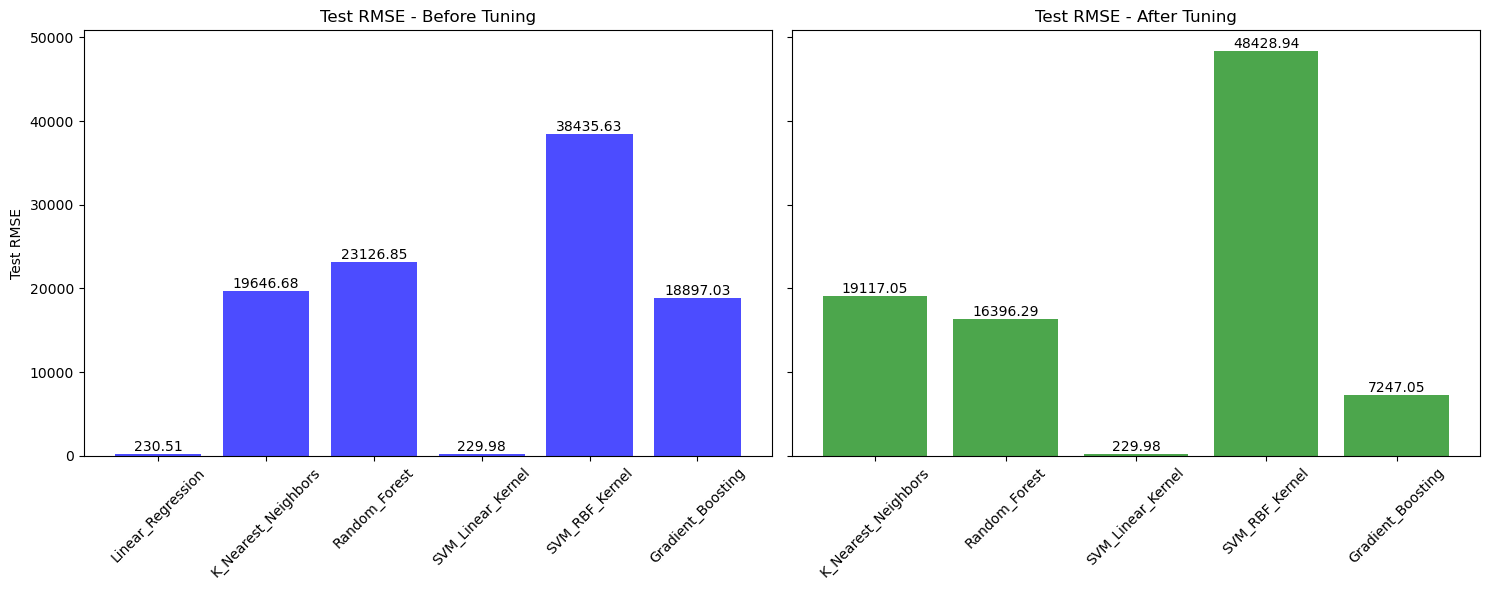

In [35]:
# Set up a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot Original Results
axes[0].bar(original_results_df.index, original_results_df["Test_RMSE"], color='blue', alpha=0.7)
axes[0].set_title("Test RMSE - Before Tuning")
axes[0].set_ylabel("Test RMSE")
axes[0].tick_params(axis='x', rotation=45)

# Plot Tuned Results
axes[1].bar(tuned_results_df.index, tuned_results_df["Test_RMSE"], color='green', alpha=0.7)
axes[1].set_title("Test RMSE - After Tuning")
axes[1].tick_params(axis='x', rotation=45)

for i, val in enumerate(original_results_df["Test_RMSE"]):
    axes[0].text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)
for i, val in enumerate(tuned_results_df["Test_RMSE"]):
    axes[1].text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

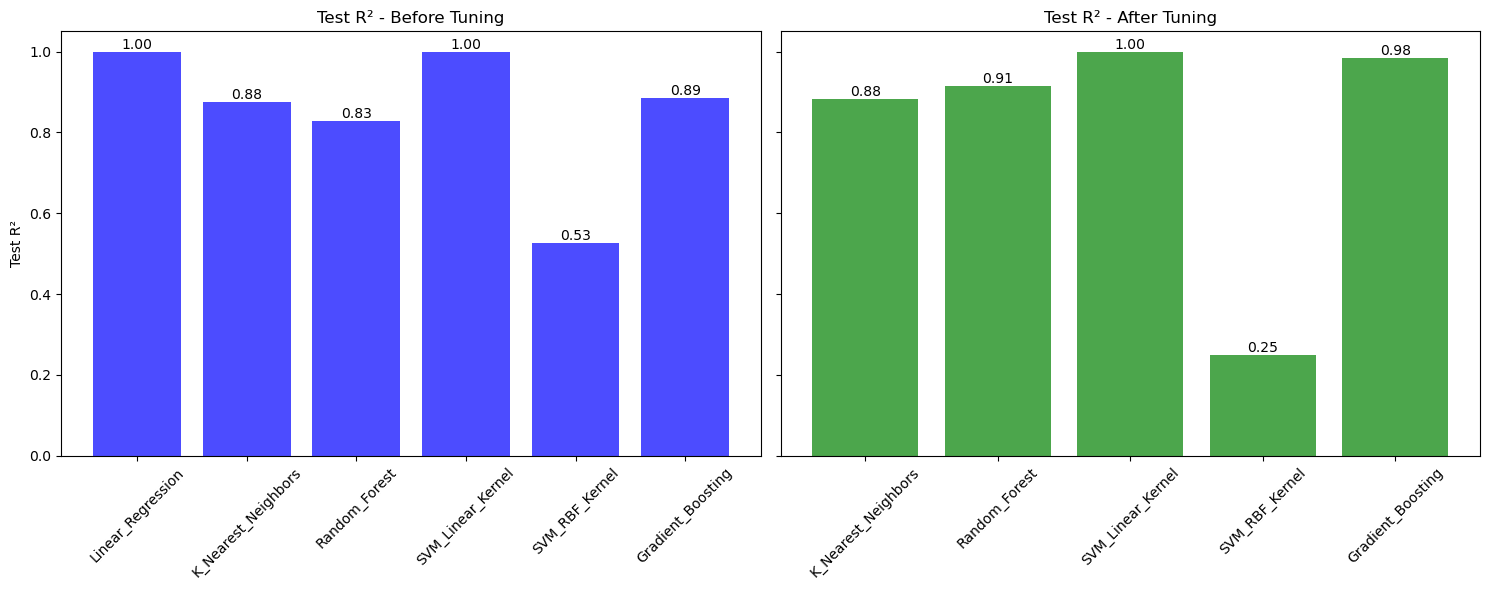

In [36]:
# Set up a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot Original Results
axes[0].bar(original_results_df.index, original_results_df["Test_R2"], color='blue', alpha=0.7)
axes[0].set_title("Test R² - Before Tuning")
axes[0].set_ylabel("Test R²")
axes[0].tick_params(axis='x', rotation=45)

# Plot Tuned Results
axes[1].bar(tuned_results_df.index, tuned_results_df["Test_R2"], color='green', alpha=0.7)
axes[1].set_title("Test R² - After Tuning")
axes[1].tick_params(axis='x', rotation=45)

for i, val in enumerate(original_results_df["Test_R2"]):
    axes[0].text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)
for i, val in enumerate(tuned_results_df["Test_R2"]):
    axes[1].text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()
